In [1]:
from mel_processing import get_melspec_from_file, calc_deltas
import os
import glob
import IPython
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np

## データセット内の音声ファイルの平均の長さを計算

Shape of waveform: torch.Size([1, 54080])
Sample rate of waveform: 16000


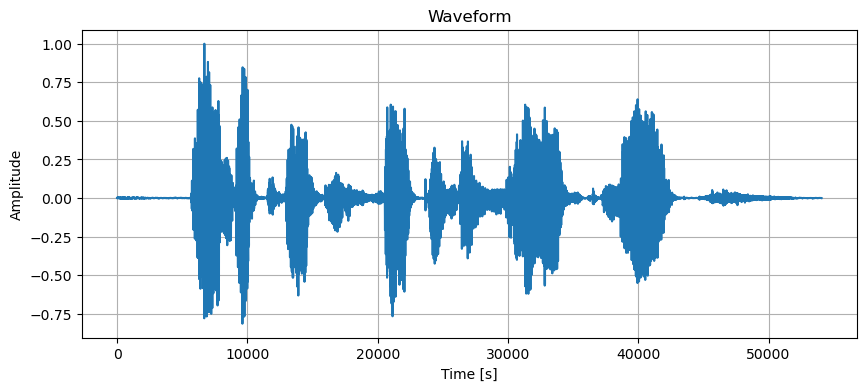

Shape of spec: torch.Size([1, 64, 301])


In [51]:
# filename = 'dataset/esd/0012/Neutral/0012_000001.wav'
filename = '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Happy/0020_000709.wav'
# filename ='/work/abelab5/t_tana/emo_clf2/dataset/jtes/wav/m14/joy/m14_joy_01.wav'
waveform, sr = torchaudio.load(filepath=filename)
sec_per_sample = 1 / sr
# 波形の形状とサンプルレートの表示
print(f"Shape of waveform: {waveform.size()}")
print(f"Sample rate of waveform: {sr}")
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
plt.title('Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

log_melspec = get_melspec_from_file(filename, 3.0, False, 25e-3, 10e-3, 25e-3, 64)
log_melspec_emph = get_melspec_from_file(filename, 3.0, True, 25e-3, 10e-3, 25e-3, 64)

print(f"Shape of spec: {log_melspec.size()}")

IPython.display.Audio(filename)



In [3]:
dataset = 'dataset/jtes'
wavpath_list = glob.glob(os.path.join(dataset, '**', '*.wav'), recursive=True)
neutral_list = [wavpath for wavpath in wavpath_list if 'Neutral' in wavpath or 'neu' in wavpath]
happy_list = [wavpath for wavpath in wavpath_list if 'Happy' in wavpath or 'joy' in wavpath]
sad_list = [wavpath for wavpath in wavpath_list if 'Sad' in wavpath or 'sad' in wavpath]
angry_list = [wavpath for wavpath in wavpath_list if 'Angry' in wavpath or 'ang' in wavpath]
surprise_list = [wavpath for wavpath in wavpath_list if 'Surprise' in wavpath]
all_dict = {'Neutral':neutral_list, 'Happy':happy_list, 'Sad':sad_list, 'Angry':angry_list, 'Surprise':surprise_list}
emotions = ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprise']
for emotion in emotions:
    print(f'{len(all_dict[emotion])=}')

len(all_dict[emotion])=5000
len(all_dict[emotion])=5000
len(all_dict[emotion])=5000
len(all_dict[emotion])=5000
len(all_dict[emotion])=0


In [ ]:
# def calc_n_sample_from_file(filename):
#     waveform, sr = torchaudio.load(filepath=filename)
#     n_sample = waveform.size(1)
#     return n_sample

# # Surpriseをのぞく音声の平均長を計算
# wavpath_list_without_surprise = [wavpath for wavpath in wavpath_list if 'Surprise' not in wavpath]
# ave_n_sample = 0
# for file in wavpath_list_without_surprise:
#     ave_n_sample += calc_n_sample_from_file(file)
# ave_n_sample //= len(wavpath_list_without_surprise)
# ave_sec = ave_n_sample*sec_per_sample
# print(f'{ave_n_sample=}')
# print(f'{ave_sec=}')


KeyboardInterrupt: 

# 波形とメルスペクトログラム，そのdeltaとdelta-delta特徴量で構成される3D-MelSpectrogram
論文（https://www.frontiersin.org/journals/physiology/articles/10.3389/fphys.2021.643202/full ）を参考に実装．

In [5]:
def plot_melspectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

# メルスペクトログラム，delta，delta-delta
あらかじめ波形をpre-emphasize(高域強調を適用)しておく．以降はこの波形を使用したメルスペクトログラムを使用．

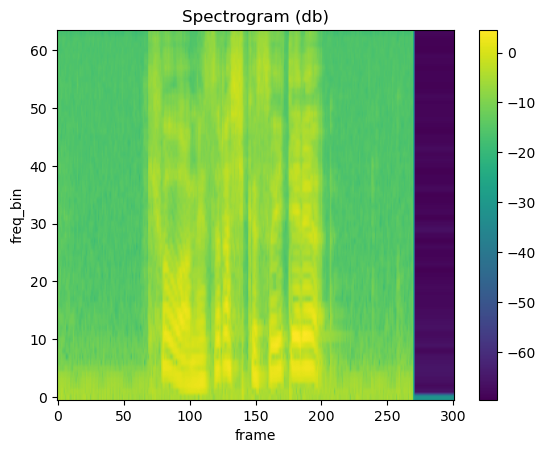

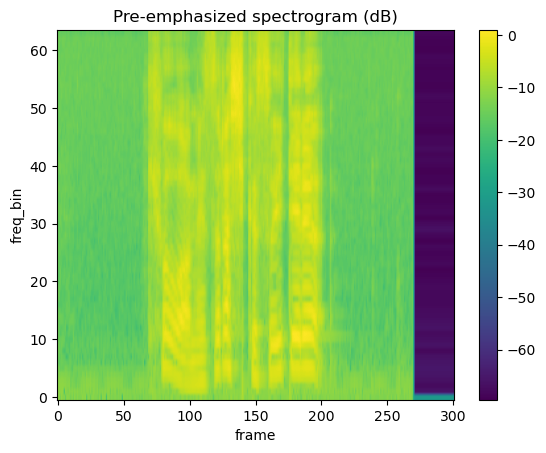

In [6]:
plot_melspectrogram(log_melspec[0])
plot_melspectrogram(log_melspec_emph[0], title='Pre-emphasized spectrogram (dB)')


torch.Size([3, 64, 301])


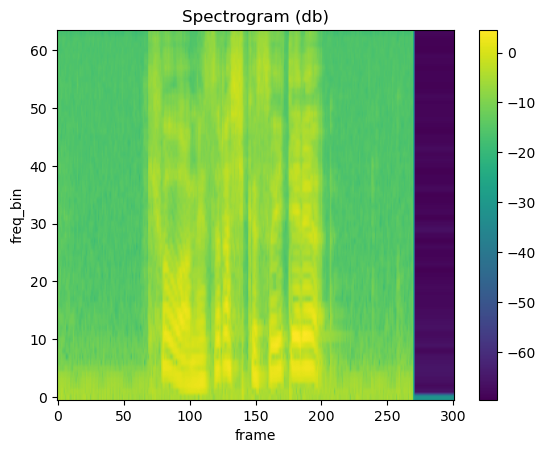

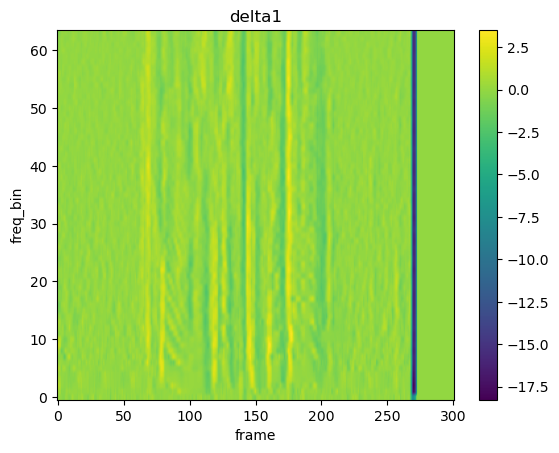

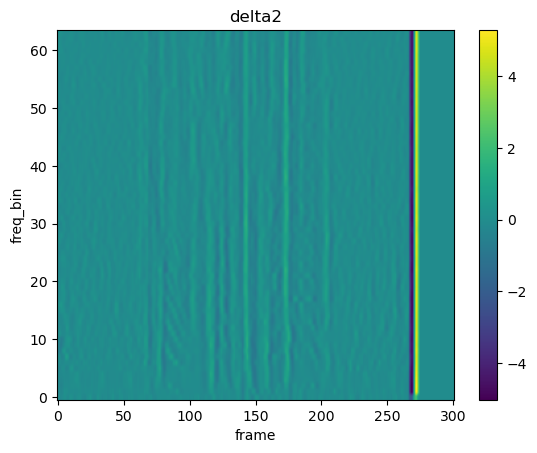

In [7]:
mel_specs_3d = calc_deltas(log_melspec)
print(mel_specs_3d.size())
plot_melspectrogram(mel_specs_3d[0])
plot_melspectrogram(mel_specs_3d[1], title='delta1')
plot_melspectrogram(mel_specs_3d[2], title='delta2')


# 3つの特徴量を重ねて，同じサイズのセグメントに分割
- normalize として0-1で正規化した場合

In [52]:
from preprocess import extract_resized_segments_from_file, get_3dmelspec_from_file, normalize_image

In [53]:
import cv2
import matplotlib.pyplot as plt

def imgShow(imgList, row_num = 1):
    img_num = len(imgList)
    
    if img_num == 1:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.imshow(imgList[0])
    
    else:
        fig, axes = plt.subplots(row_num, round(img_num / row_num))
        ax = axes.ravel()
        for i in range(img_num):
            ax[i].imshow(imgList[i])
            ax[i].axis('off')

    plt.show()

def show_segments(filename, normalizer=None, max_sec=3.0):
    segments = extract_resized_segments_from_file(filename, normalizer=normalizer, max_sec=max_sec)
    print(f'{segments.size()=}')
    imgs = [segments[idx].permute(*torch.arange(segments[idx].ndim - 1, -1, -1)).permute(1, 0, 2) for idx in range(segments.size(0))]
    imgShow(imgs)
    return segments



/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Happy/0020_000709.wav


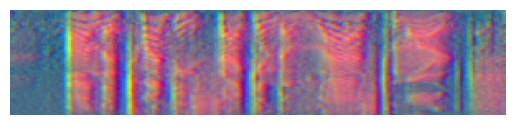

In [54]:
print(filename)
melspec_3d = get_3dmelspec_from_file(filepath=filename, max_sec=3.0, pre_emph=True, fft_sec=25e-3, hop_sec=10e-3, window_sec=25e-3, n_mels=64)
melspec_3d = normalize_image(melspec_3d)
plt.imshow(melspec_3d.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

学習スクリプトの実装では最大長は全音声の平均長ではなく，3sにしているが，以下はデータセットの平均長を最大長にしているため，7枚の画像になる．（3sの場合は8枚になる）

segments.size()=torch.Size([8, 3, 227, 227])


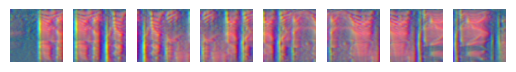

tensor([[[0.2272, 0.2272, 0.2274,  ..., 0.3505, 0.3547, 0.3547],
         [0.2272, 0.2272, 0.2274,  ..., 0.3505, 0.3547, 0.3547],
         [0.2388, 0.2388, 0.2422,  ..., 0.3716, 0.3740, 0.3740],
         ...,
         [0.5600, 0.5600, 0.5636,  ..., 0.3553, 0.3526, 0.3526],
         [0.5572, 0.5572, 0.5611,  ..., 0.3680, 0.3648, 0.3648],
         [0.5572, 0.5572, 0.5611,  ..., 0.3680, 0.3648, 0.3648]],

        [[0.4877, 0.4877, 0.4820,  ..., 0.4528, 0.4586, 0.4586],
         [0.4877, 0.4877, 0.4820,  ..., 0.4528, 0.4586, 0.4586],
         [0.4749, 0.4749, 0.4721,  ..., 0.4452, 0.4498, 0.4498],
         ...,
         [0.5111, 0.5111, 0.5036,  ..., 0.3480, 0.3488, 0.3488],
         [0.5173, 0.5173, 0.5085,  ..., 0.3418, 0.3416, 0.3416],
         [0.5173, 0.5173, 0.5085,  ..., 0.3418, 0.3416, 0.3416]],

        [[0.5630, 0.5630, 0.5611,  ..., 0.4954, 0.4885, 0.4885],
         [0.5630, 0.5630, 0.5611,  ..., 0.4954, 0.4885, 0.4885],
         [0.5804, 0.5804, 0.5764,  ..., 0.5027, 0.4980, 0.

In [55]:
segments = show_segments(filename, max_sec=3)
print(segments[6])

- 0-1normalize + ImageNetの設定でnormalizeの場合

注）RGBの値ではないので正常に表示不可能

In [47]:
import torchvision.transforms as T
ave_sec = 3

segments.size()=torch.Size([8, 3, 227, 227])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


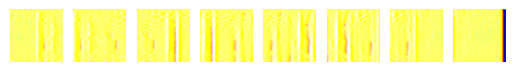

tensor([[[1.0942, 1.0942, 1.0777,  ..., 1.3821, 1.3795, 1.3795],
         [1.0942, 1.0942, 1.0777,  ..., 1.3821, 1.3795, 1.3795],
         [1.1076, 1.1076, 1.0943,  ..., 1.3223, 1.3182, 1.3182],
         ...,
         [1.6342, 1.6342, 1.6408,  ..., 1.0897, 1.0943, 1.0943],
         [1.6158, 1.6158, 1.6217,  ..., 1.0932, 1.0986, 1.0986],
         [1.6158, 1.6158, 1.6217,  ..., 1.0932, 1.0986, 1.0986]],

        [[1.3854, 1.3854, 1.3823,  ..., 1.2773, 1.2774, 1.2774],
         [1.3854, 1.3854, 1.3823,  ..., 1.2773, 1.2774, 1.2774],
         [1.3966, 1.3966, 1.3872,  ..., 1.2433, 1.2341, 1.2341],
         ...,
         [1.4046, 1.4046, 1.3973,  ..., 1.3164, 1.3168, 1.3168],
         [1.4138, 1.4138, 1.4082,  ..., 1.3231, 1.3237, 1.3237],
         [1.4138, 1.4138, 1.4082,  ..., 1.3231, 1.3237, 1.3237]],

        [[0.4649, 0.4649, 0.4667,  ..., 0.3704, 0.3672, 0.3672],
         [0.4649, 0.4649, 0.4667,  ..., 0.3704, 0.3672, 0.3672],
         [0.4262, 0.4262, 0.4268,  ..., 0.3634, 0.3642, 0.

In [48]:
segments = show_segments(filename, normalizer=T.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), max_sec=ave_sec)
print(segments[6])

# その他の音声を見る

- 同じ文で同じ感情，異なる話者の場合

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0017/Angry/0017_000351.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


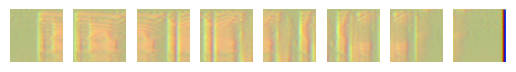

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0018/Angry/0018_000351.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


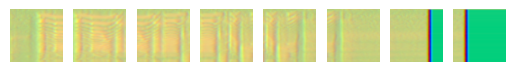

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0012/Angry/0012_000351.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


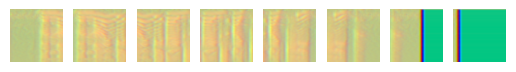

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000351.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


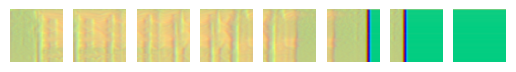

In [49]:
filelist = ['/work/abelab5/t_tana/emo_clf2/dataset/esd/0017/Angry/0017_000351.wav', 
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0018/Angry/0018_000351.wav',
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0012/Angry/0012_000351.wav', 
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000351.wav',]

for file in filelist:
    print(f'listen {file} ↓')
    IPython.display.display(IPython.display.Audio(file))
    show_segments(file, max_sec=ave_sec)

- 同じ文で同じ話者，感情が異なる場合

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000359.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


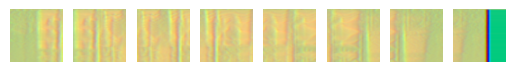

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Happy/0020_000709.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


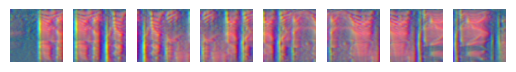

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Neutral/0020_000009.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


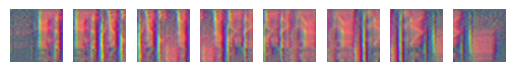

listen /work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Sad/0020_001059.wav ↓


segments.size()=torch.Size([8, 3, 227, 227])


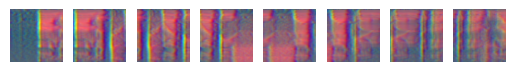

In [50]:
filelist = ['/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Angry/0020_000359.wav',
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Happy/0020_000709.wav', 
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Neutral/0020_000009.wav',
            '/work/abelab5/t_tana/emo_clf2/dataset/esd/0020/Sad/0020_001059.wav']

for file in filelist:
    print(f'listen {file} ↓')
    IPython.display.display(IPython.display.Audio(file))
    show_segments(file, max_sec=ave_sec)

In [ ]:
from inference import inference

model_path = 